In [ ]:
# Performed LDA and CSP on epoch=1.0 and sfreq=250 on paired raw data from Fall 2025 crude collection.
# Ceiling-ed at ~57% accuracy on binary clf.

In [8]:
# for data loading mostly
import numpy as np
import pandas as pd
import mne
import os

# for csp and lda
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_score

In [9]:
# pretty sure sfreq is 250hz

def csv_to_raw(csv_path, sfreq, eeg_chs):
    df = pd.read_csv(csv_path, index_col=0)

    
    data = df[eeg_chs].values.T  # (channels, samples)

    info = mne.create_info(
        ch_names=eeg_chs,
        sfreq=sfreq,
        ch_types=["eeg"] * len(eeg_chs)
    )

    raw = mne.io.RawArray(data, info)
    raw.set_montage("standard_1020")

    return raw

In [10]:
# double check the convresion of the csv

raw = csv_to_raw("data/leg-mi/Experiment_#1_LEG_MI.csv", sfreq=250, eeg_chs=['Fz','C3','Cz','C4'])
print(raw.info)
print(raw.get_data().shape)

Creating RawArray with float64 data, n_channels=4, n_times=5102
    Range : 0 ... 5101 =      0.000 ...    20.404 secs
Ready.


<Info | 8 non-empty values
 bads: []
 ch_names: Fz, C3, Cz, C4
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 250.0 Hz
>
(4, 5102)


In [ ]:
sfreq = 250 # CHECK
# Adding Fz lowers acc --> good
eeg_chs = ['C3', 'Cz', 'C4']

In [12]:
mi_dir = "data/leg-mi"
mi_paths = [os.path.join(mi_dir, f) for f in os.listdir(mi_dir)]

ctrl_dir = "data/rest"
ctrl_paths = [os.path.join(ctrl_dir, f) for f in os.listdir(ctrl_dir)]

print(mi_paths)
print(ctrl_paths)

['data/leg-mi/Experiment_#2_LEG_MI.csv', 'data/leg-mi/Experiment_#5_LEG_MI.csv', 'data/leg-mi/Experiment_#3_LEG_MI.csv', 'data/leg-mi/Experiment_#1_LEG_MI.csv', 'data/leg-mi/Experiment_#4_LEG_MI.csv']
['data/rest/Experiment_#3_Control.csv', 'data/rest/Experiment_#5_Control.csv', 'data/rest/Experiment_#2_Control.csv', 'data/rest/Experiment_#4_Control.csv', 'data/rest/Experiment_#1_Control.csv']


In [14]:
def epochs_from_file(csv_path, label, sfreq, eeg_chs, epoch_len=2.0):
    raw = csv_to_raw(csv_path, sfreq, eeg_chs)
    raw.filter(8, 30, picks='eeg')

    epochs = mne.make_fixed_length_epochs(
        raw,
        duration=epoch_len,
        overlap=0.0, ## try with 0 overlap since it might be clean
        preload=True
    )

    X = epochs.get_data()
    y = np.full(len(X), label, dtype=int)

    return X, y

In [15]:
mi_dir = "data/leg-mi"
ctrl_dir = "data/rest"

mi_paths = sorted([os.path.join(mi_dir, f) for f in os.listdir(mi_dir)])
ctrl_paths = sorted([os.path.join(ctrl_dir, f) for f in os.listdir(ctrl_dir)])

assert len(mi_paths) == len(ctrl_paths), "MI and REST trials must be paired!"

In [16]:
X_list = []
y_list = []
groups = []

epoch_len = 1.0
block_id = 0

for mi_f, ctrl_f in zip(mi_paths, ctrl_paths):

    # ---- MI trial ----
    X_mi, y_mi = epochs_from_file(
        mi_f, label=1,
        sfreq=sfreq,
        eeg_chs=eeg_chs,
        epoch_len=epoch_len
    )
    X_list.append(X_mi)
    y_list.append(y_mi)
    groups.extend([block_id] * len(X_mi))

    # ---- REST trial ----
    X_ctrl, y_ctrl = epochs_from_file(
        ctrl_f, label=0,
        sfreq=sfreq,
        eeg_chs=eeg_chs,
        epoch_len=epoch_len
    )
    X_list.append(X_ctrl)
    y_list.append(y_ctrl)
    groups.extend([block_id] * len(X_ctrl))

    block_id += 1

Creating RawArray with float64 data, n_channels=4, n_times=5102
    Range : 0 ... 5101 =      0.000 ...    20.404 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 250 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=4, n_times=5060
    Range : 0 ... 5059 =      0.000 ...    20.

In [17]:
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
groups = np.array(groups)

print("X shape:", X.shape)   # (n_epochs, n_ch, n_times)
print("y shape:", y.shape)
print("groups:", np.unique(groups))

X shape: (195, 4, 250)
y shape: (195,)
groups: [0 1 2 3 4]


In [18]:
cv = GroupKFold(n_splits=5)

for i, (tr, te) in enumerate(cv.split(X, y, groups)):
    print(f"Fold {i}")
    print(" train:", np.bincount(y[tr]))
    print(" test :", np.bincount(y[te]))

Fold 0
 train: [77 78]
 test : [20 20]
Fold 1
 train: [77 78]
 test : [20 20]
Fold 2
 train: [78 78]
 test : [19 20]
Fold 3
 train: [78 79]
 test : [19 19]
Fold 4
 train: [78 79]
 test : [19 19]


In [19]:
pipeline = Pipeline([
    ("csp", CSP(
        n_components=2,
        reg="ledoit_wolf",   # STABILIZES covariance for small data
        log=True
    )),
    ("lda", LinearDiscriminantAnalysis())
])

In [20]:
scores = cross_val_score(
    pipeline,
    X,
    y,
    groups=groups,
    cv=cv,
    scoring="accuracy"
)

print("Fold accuracies:", scores)
print("Mean accuracy:", scores.mean())

Computing rank from data with rank=None
    Using tolerance 3.4e+03 (2.2e-16 eps * 4 dim * 3.9e+18  max singular value)
    Estimated rank (data): 4
    data: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 2.9e+03 (2.2e-16 eps * 4 dim * 3.3e+18  max singular value)
    Estimated rank (data): 4
    data: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3e+03 (2.2e-16 eps * 4 dim * 3.4e+18  max singular value)
    Estimated rank (data): 4
    data: rank 4 computed from 4 data channels with 0 projectors
Reducing data rank from 4 -> 4
Estimating class=0 covariance using LEDOIT_WOLF
Don

Computing rank from data with rank=None
    Using tolerance 2.4e+03 (2.2e-16 eps * 3 dim * 3.6e+18  max singular value)
    Estimated rank (data): 3
    data: rank 3 computed from 3 data channels with 0 projectors
Reducing data rank from 3 -> 3
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
NOTE: plot_patterns() is a legacy function. New code should use get_spatial_filter_from_estimator(clf, info=info).plot_patterns().


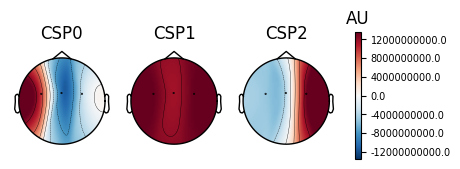

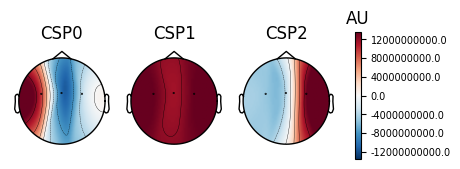

In [14]:
# trying csp fitting now

pipeline.fit(X, y) 
csp = pipeline.named_steps['csp']
csp.plot_patterns(info=raw.info)